# Tutorial on processing and analyzing PAX polarization datasets

<font color='red'>Updated: 2024/06/17

<font color='red'>Author: Evan McClintock

## Introduction

To fully characterize the PTF of a fiber optic cable at any point in time (call it $R_C(t)$), one must measure the effect of $R_C$ on *two* linearly independent input SOPs: $V_{1,out} = R_C V_{1,in}$ and $V_{2,out} = R_C V_{2,in}$. The two input states $V_{1,in}$ and $V_{2,in}$ are rapidly alternated in time and transmitted through the DUT. The PAX polarimeter measures $V_{1,out}$ and $V_{2,out}$ as they are alternated in time.

It was observed that the PAX has an extremely poor and inconsistent measurement rate; [this](www.google.com) github repositiory provides a few quick tools (also included here) to characterize variability in the Time Between Samples (TBS) in any PAX dataset. This variability makes it impossible to systematically separate the two output SOPs in time by the number of samples taken. It also seemed highly difficult to synchronize the clock of the waveform generator with that of the PAX (not to mention the variability in the frequency of the generated waveform), so we opted for a programmatic approach to automatically identify the time-alternating behavior and separate the output SOPs for further analysis.

The functions of this github repository are to:
1. Automatically identify the change-points (a.k.a. "switches") between the two SOPs and perform initial processing of the measurement data.
2. Provide tools for subsequent SOP visualization and analysis.

## Overview

Processing a PAX dataset consists of four steps:
1. Read in the raw data
2. Identify the switches (change points)
3. Separate the SOPs and average the data within each segment
4. Calculate drift in the PTF

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib
#matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib tk
#%matplotlib inline
import pandas as pd
#from datetime import timedelta
import allantools #https://allantools.readthedocs.io/en/latest/functions.html
import os
import scipy.stats as ss
import pickle
#import copy
#import math
#import time
#import seaborn as sns
#import warnings
BOLD_ON = "\033[1m"
BOLD_OFF = "\033[0m"

In [2]:
# Import data analysis code
import importlib
import data_manager
importlib.reload(data_manager)
from data_manager.dataset import Dataset
from data_manager.stationary import StationarySet
from data_manager.switch import SwitchSet
import data_manager.utils.plotting_utils as P
from data_manager.utils.hourly_dividing_utils import Divider
from data_manager.pairs import IOPair

In [3]:
# Directory information
LAB = "/mnt/c/Users/2020n/Documents/Career/Locations/Britton Lab/"   # Path to lab folder
DATA = LAB + "QWDM_Project/H1_Datasets/"   # Path to folder of datasets

In [4]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/home/evanshaped/anaconda3/envs/britton2024envWSL/bin/python
3.12.2 | packaged by conda-forge | (main, Feb 16 2024, 20:50:58) [GCC 12.3.0]
sys.version_info(major=3, minor=12, micro=2, releaselevel='final', serial=0)


## Example of automatic processing

### Read in raw dataset

Here, we read in, clean, and visualize a raw dataset from the PAX.

**`class SwitchSet(filename, set_range=None, skip_default_signal_baseline=0.0)`**\
Stores and processes data from the PAX1000 polarimeter. Upon initializing a SwitchSet instance, data from the PAX csv file is cleaned. See the PAX [manual](https://www.manualslib.com/manual/1634678/Thorlabs-Pax1000.html?page=39#manual) for details on the recorded quantities.

**Parameters**
- **filename:** ***String***\
  The name of the file to be processed, including the file extension. Example: `filename="/path/to/folder/name_of_file.csv"

- **set_range:** ***Tuple[float, float], optional***\
  The range of data to read. Default is None (read all avaliable data). Use tuple of two floats to specify the percentage of data to read (reading the entirety of large datasets takes a long time). For example, set_range=(0.05,0.1) specifies the chunk of the dataset between 5% and 10%.

- **skip_default_signal_baseline:** ***float, optional***\
  How many seconds of data from the beginning of the dataset to discard.

**`SwitchSet.print_info()`**\
Print the metainformation obtained from the csv file (PAX configuration and basic dataset info).

**`SwitchSet.plot_raw(birds_eye=True,plot_param='s1',sample_range=None,plot_switch=False,plot_avg=False)`**\
Plots the raw data over the given range of time, with the option to show the results of processing steps.

**Parameters**
- **birds_eye:** ***bool, default: True***\
  Whether to plot the "birds eye" view (the entirety) of the dataset.

- **plot_param:** ***String, default: 's1'***\
  Which parameter to plot. See the PAX [manual](https://www.manualslib.com/manual/1634678/Thorlabs-Pax1000.html?page=39#manual) for details on the recorded quantities. Options are:
  * 's1', 's2', 's3' - Normalized stokes parameters (unitless)
  * 'S0', 'S1', 'S2', 'S3' - Unnormalized stokes parameters (in mW)
  * 'Azimuth', 'Ellipticity' - Polarization ellipse angles (in degrees)
  * 'DOP', 'DOCP', 'DOLP' - Degree of polarization, degree of circular polarization, degree of linear polarization (all in %)
  * 'Power', 'Power_pol', 'Power_unpol' - Total power, polarized power, unpolarized power (all in mW)
  * 'Power_split_ratio' - See PAX manual (unitless)
  * 'Phase_difference' - See PAX manual (unitless)
<br><br>
- **sample_range:** ***Tuple[float, float], optional***\
  If provided, plots a zoomed in view of the dataset around the time range given (i.e., `sample_range=(15,20)` plots from t = 15 seconds to t = 20 seconds). By default, the zoomed in view is not plotted

- **plot_switch:** ***bool, default: False***\
  Only has an effect after `SwitchSet.find_switches(...)` has been run. Plots the detected switch jumps, and estimated switch times. Samples that are kept for analysis are plotted in blue, while samples that were discarded (for risk of being too close to the switch times and mis-measured) remain plotted in red.

- **plot_avg:** ***bool, default: False***\
  Only has an effect after `SwitchSet.average_data(...)` has been run. Once each 'segment' of valid data is identified and averaged, the averaged point for each segment is plotted.

Initialize a `SwitchSet` object with the csv file and information on how much data to read. Below, we read in the first 2% of this dataset using `set_range=(0,0.02)`. We set `skip_default_signal_baseline=0.0` so we don't skip any of the initial data.

In [5]:
# Read in raw dataset
filename = DATA + 'Whole_setup/24-03-13/PAX_3-13_ARL_Orth_2_1345_desktop.csv'
ds_1345 = SwitchSet(filename, set_range=(0,0.02), skip_default_signal_baseline=0.0)

Time range: min=0.1, max=839.536


First, lets print the metainformation obtained from the header of the csv file and some information about the dataset after processing. Note the discrepancy between the nominal sample rate (200Hz) and the (average) sample rate actually recorded (52Hz).

In [6]:
ds_1345.print_info()

=== PAX Configuration parameters ===
Device ID: PAX1000IR2
Serial number: M00572108
Wavelength (nm): 1345.00
Basic Sample Rate (Hz): 400.0
Operating Mode Period (# of rotations): 1.0
Operating Mode FFT Points: 1024
--> Nominal Sample Rate (Hz): 200.00

=== Dataset information ===
Filename: /mnt/c/Users/2020n/Documents/Career/Locations/Britton Lab/QWDM_Project/H1_Datasets/Whole_setup/24-03-13/PAX_3-13_ARL_Orth_2_1345_desktop.csv
Time range read (seconds): min=0.10, max=839.54
Average Sample Rate (Hz): 52.35


Now we examine what the dataset looks like. Using `SwitchSet.plot_raw(...)`, we plot a birds-eye view of the dataset, and a view zoomed in on the first few seconds. Change around the `sample_range` parameter to explore different parts of the dataset.

By default, the first normalized stokes parameter (s1) is plotted, but we can change this using `plot_param='s2'` or `plot_param='power'`, for example.

Note the title of each plot: **plotted parameter | dataset title | range of time shown in this plot**

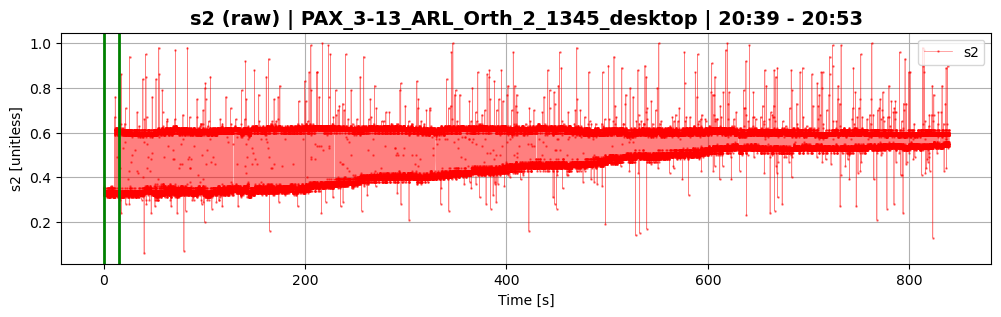

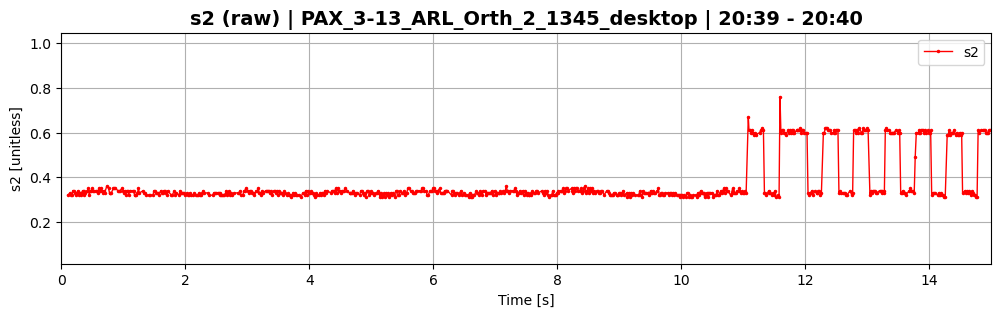

In [7]:
# Plot example section
ds_1345.plot_raw(plot_param='s2', sample_range=(0, 15), birds_eye=True)

We see that the first ~12 or so seconds were used to let the default SOP run by itself and to synchronize the OMSs. Now that we know what the data looks like, we can re-instantiate the `SwitchSet` object with more data and ignore the first few seconds where the experiment was being initialized. We'll read in 10% of the data this time, and skip the first 15 seconds.

In [8]:
ds_1345 = SwitchSet(filename, set_range=(0,0.1), skip_default_signal_baseline=15)

Time range: min=15.026, max=4162.506


### Locate switch times

We'd like the code to identify the switch times automatically, using `SwitchSet.find_switches(...)`.

**`SwitchSet.find_switches(nominal_switch_rate=2, change_point_range_1=None, change_point_range_2=None, n_exclude=3, print_process=False)`**\
    Description
  
**Parameters**
- **nominal_switch_rate:** ***float, default: 2.0***\
  Text

- **change_point_range_1:** ***Tuple[float, float], optional***\
  Text

- **change_point_range_2:** ***Tuple[float, float], optional***\
  Text

- **n_exclude:** ***int, default: 3***\
  Text

- **print_process:** ***bool, default: False***\
  Text

For nearly all purposes, the only parameter you need to worry about `nominal_switch_rate` (the rate, in Hz, with which the OMS alternates between transmitting SOPs).

You may also wish to set `print_process = True` to debug or visualize what the code is doing. The `change_point_range` parameters will be determined automatically based on the length of provided data, *but the program assumes that the first ~12 seconds of initialization data was skipped when creating the dataset.*

In the example below, `print_process` is set to `True`; if you wish, you may examine and see what the code does to identify the switch times. In general, however, this code is reliable and does not need oversight.

Determining change point ranges automatically...
Using change_point_range_1=(15.026, 115.026)
Using change_point_range_2=(3015.026, 3115.026)
=== performing change point detection ===
cp range: (15.026, 115.026)
using 5162 data entries
skipping 0 points
considering params: ['s1', 's2', 's3']

--- switch param: s1 ---
size of data we are using = (5162,)
computing range... ---> range = (1.04,1.10)
displaying jump_fig for switch parameter = s1



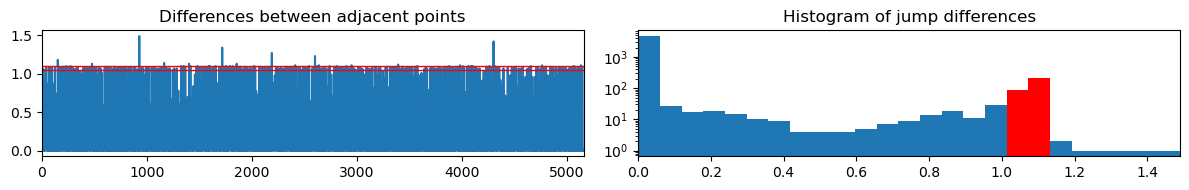



found width of 0.060 for s1
greater than prev width of -1.000 for None
--- end of switch param: s1 ---

--- switch param: s2 ---
size of data we are using = (5162,)
computing range... ---> range = (0.24,0.30)
displaying jump_fig for switch parameter = s2



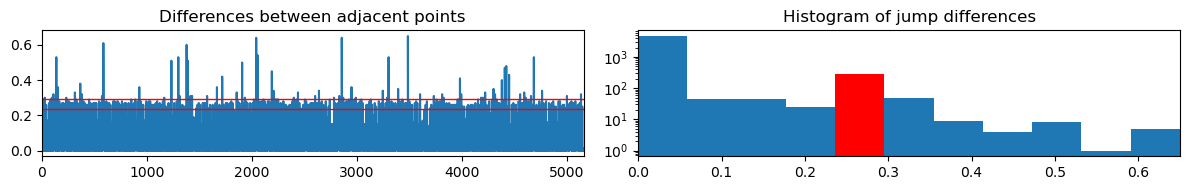



--- end of switch param: s2 ---

--- switch param: s3 ---
size of data we are using = (5162,)
computing range... ---> range = (0.69,0.75)
displaying jump_fig for switch parameter = s3



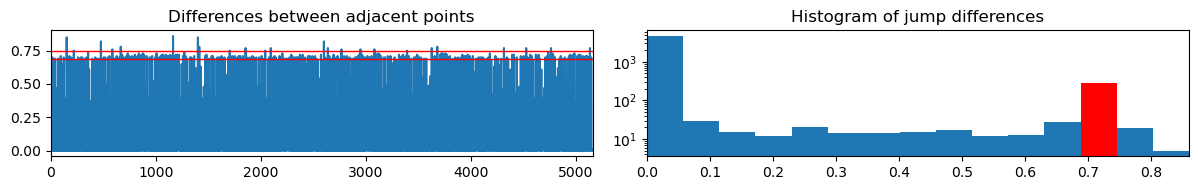



--- end of switch param: s3 ---

---> switch parameter found: s1 <---
finding differences within range = (1.04,1.10)
Jump points detected: 276
out of total: ~399.9

computing offset...


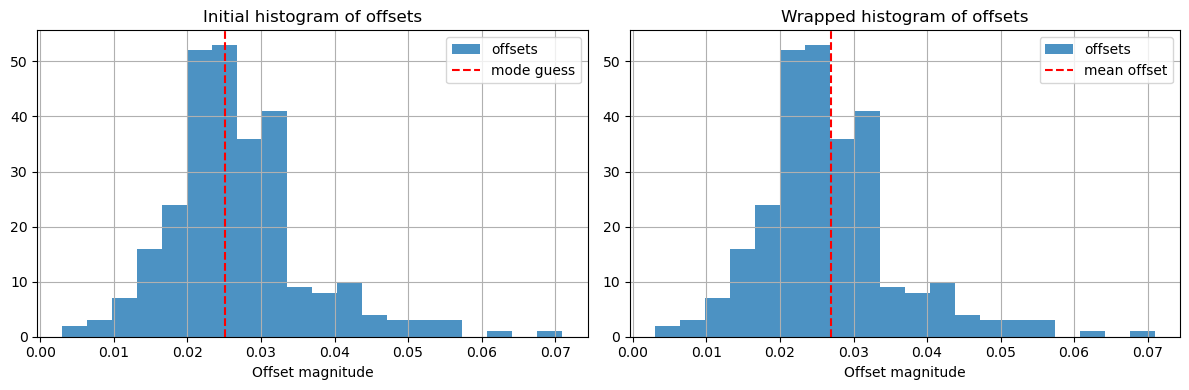



offset = 0.027 seconds
=== end change point detection ===
=== performing change point detection ===
cp range: (3015.026, 3115.026)
using 5283 data entries
skipping 158434 points
considering params: ['s1', 's2', 's3']

--- switch param: s1 ---
size of data we are using = (5283,)
computing range... ---> range = (1.00,1.06)
displaying jump_fig for switch parameter = s1



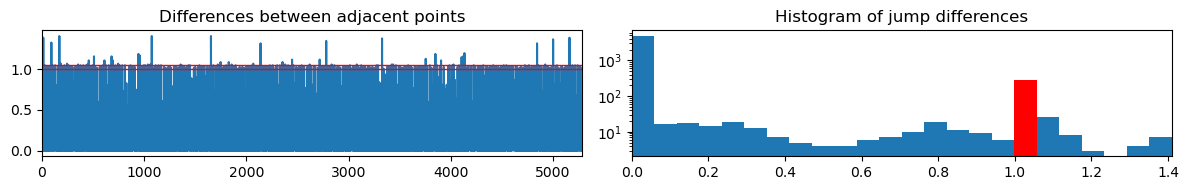



found width of 0.059 for s1
greater than prev width of -1.000 for None
--- end of switch param: s1 ---

--- switch param: s2 ---
size of data we are using = (5283,)
computing range... ---> range = (0.47,0.53)
displaying jump_fig for switch parameter = s2



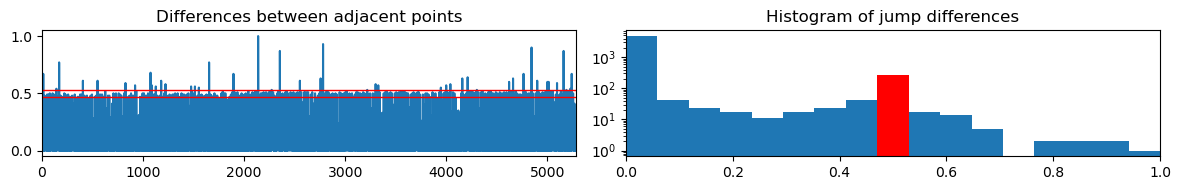



found width of 0.059 for s2
greater than prev width of 0.059 for s1
--- end of switch param: s2 ---

--- switch param: s3 ---
size of data we are using = (5283,)
computing range... ---> range = (0.58,0.64)
displaying jump_fig for switch parameter = s3



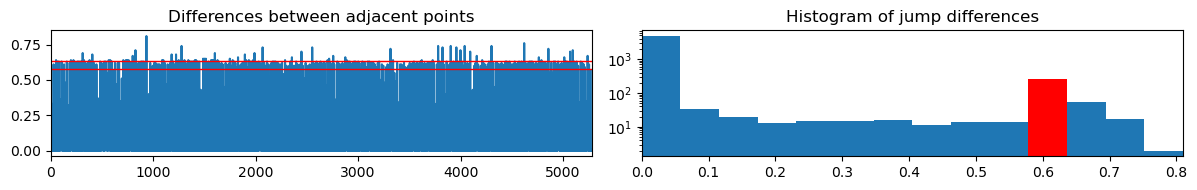



--- end of switch param: s3 ---

---> switch parameter found: s2 <---
finding differences within range = (0.47,0.53)
Jump points detected: 268
out of total: ~400.0

computing offset...


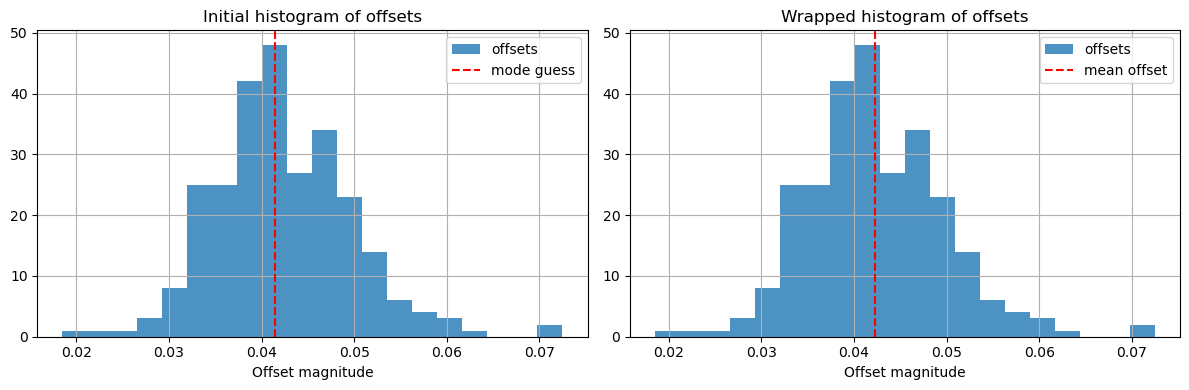



offset = 0.042 seconds
=== end change point detection ===
Nominal Switch Time = 0.2500000
Offset change of 0.015 seconds over 12000.0 switches
Corrected Switch Time = 0.2500013


In [9]:
ds_1345.find_switches(nominal_switch_rate=2, print_process=True)

Now we can set `plot_switch=True` to plot the results of `SwitchSet.find_switches(...)`. The detected jumps that correspond to switches are plotted in orange. Vertical purple lines mark the estimated switch times. Discarded samples remain plotted in red, while samples that will be used for analysis are plotted in blue.

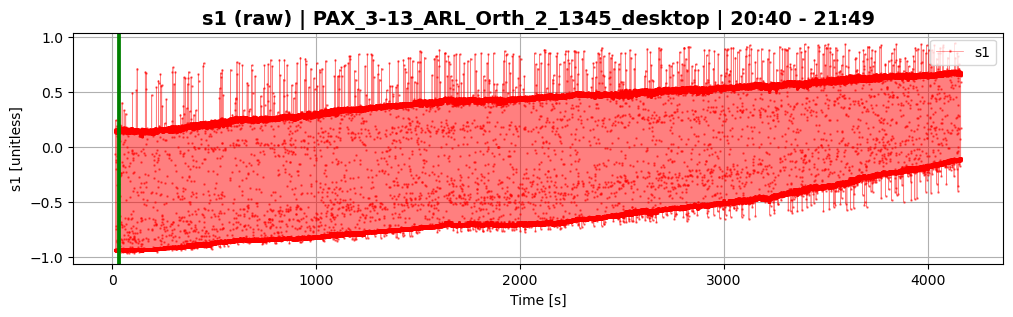

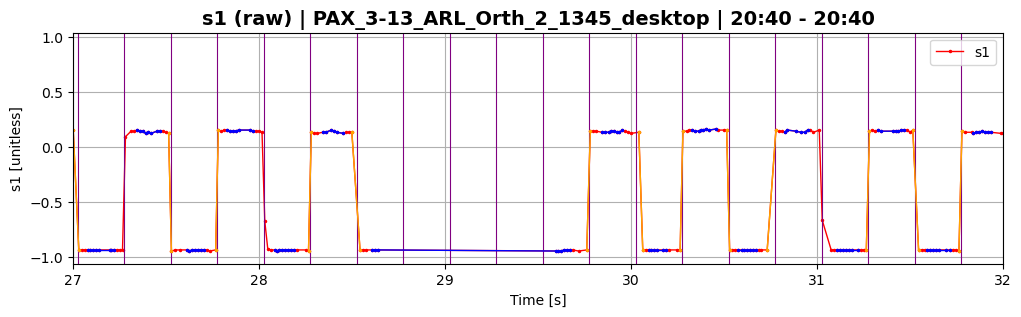

In [10]:
ds_1345.plot_raw(sample_range=(27,32), birds_eye=True, plot_switch=True)

### Average data

Within each 'segment' of valid data, we'd like to average the samples. Use `SwitchSet.average_data(...)` to do this.

**`SwitchSet.average_data(print_process=False, print_assignment=False)`**\
    Description
  
**Parameters**
- **print_process:** ***bool, default: False***\
  Text

- **print_assignment:** ***bool, default: False***\
  Text

`print_process` and `print_assignment` are only used for debugging purposes.

In [11]:
ds_1345.average_data(print_process=True, print_assignment=True)

=== starting average_data ===
averaging data... Done
Dropped 41 observations with <4 points (out of total 16424 observations)

--- interpolating data ---
length before: 8191
length after: 8294
103 total added
--- end interpolating data ---

--- interpolating data ---
length before: 8192
length after: 8294
102 total added
--- end interpolating data ---
	Choosing assign_by parameter automatically; 	Using assign_by = "s1Avg" where dif = -1.08
	Dif = -1.08 for s1Avg is negative; switching signals
Signal 1 size=8294	Signal 1 range: t=(15.65,4162.17)
Signal 2 size=8294	Signal 2 range: t=(15.40,4161.92)
	First measurement of Signal 1:  [-0.010475, 0.003691, -0.0009224624999999999]
	First measurement of Signal 2:  [0.001573857142857143, 0.0068577142857142856, -0.008868857142857142]
=== end average_data ===


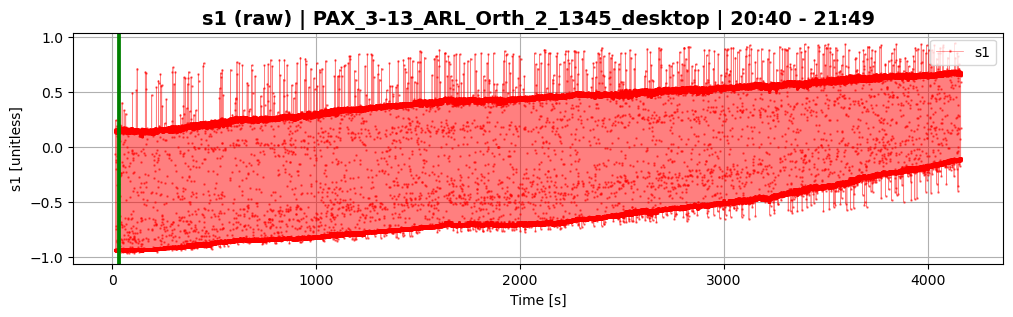

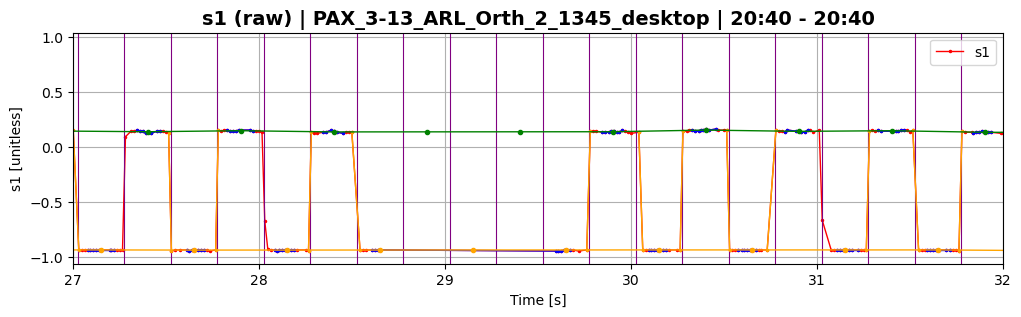

In [12]:
ds_1345.plot_raw(sample_range=(27,32), birds_eye=True, plot_switch=True, plot_avg=True)

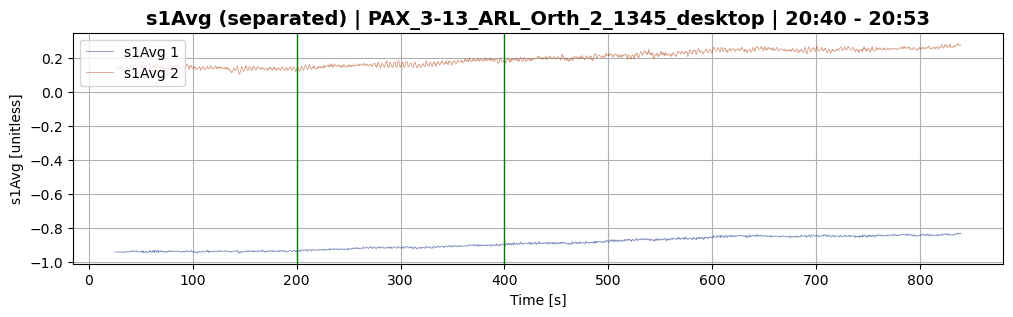

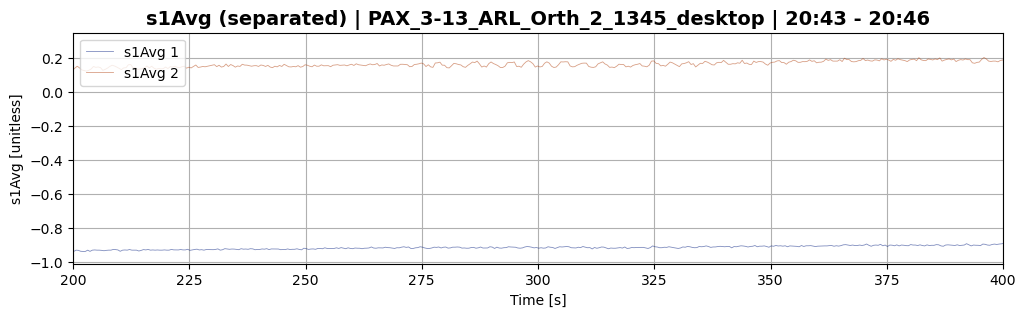

In [12]:
ds_1345.plot_separated(plot_param='s1Avg', sample_range=(200,400))

### Calcuate stokes PTF

In [13]:
reset_times_1345 = ds_1345.calc_stokes_ptf(reference=None, angle_threshold_deg=5, reset_by_rolling=True, rolling_pts=5, print_process=True);

Using "resetting reference SOPs" approach with threshold = 5.0 degrees
Averaging rotAngle using 5 rolling points
Reference matrix was reset 2 times
Reset at time t=283.03
Reset at time t=499.03


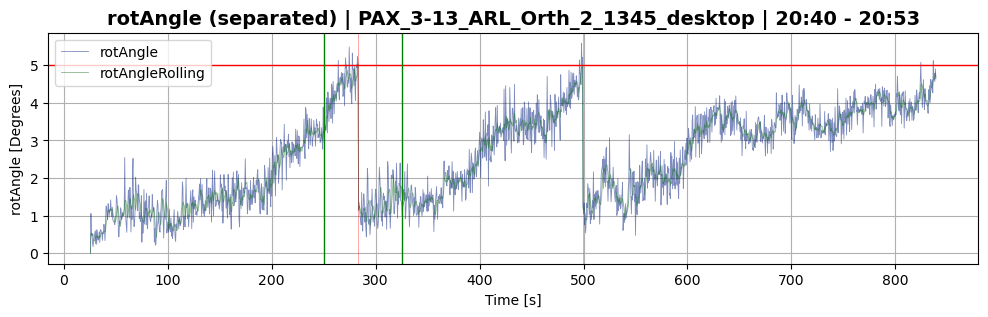

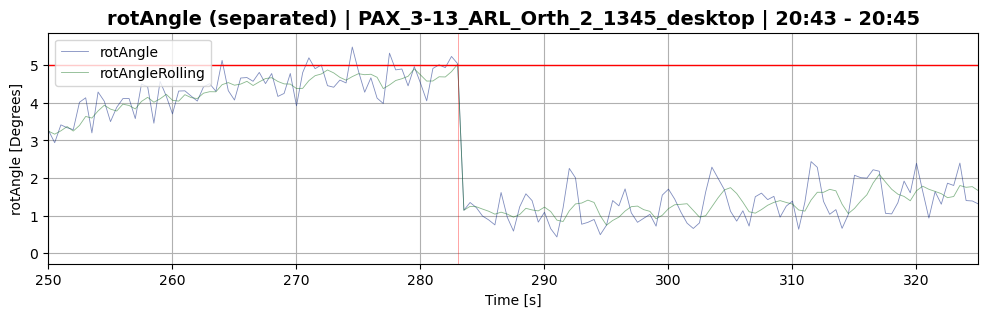

In [14]:
ds_1345.plot_separated(plot_param='rotAngle', sample_range=(250,325))

In [18]:
div = Divider(ds_1345)
params_arr = div.calc_adev_divided()

In [19]:
div.segment_dict

{}

In [17]:
params_arr

[]

In [ ]:
P.plot_adev(params_arr)